# ResNet50

In [3]:
# Importing necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.models import resnet34
from torch.utils.data import random_split
from torch.utils.data import WeightedRandomSampler
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
import time
import random
import os
import shutil
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pprint
import timm
import pytorch_lightning as pl
import logging
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Importing modules
from resnet50_config import hyperparameters
from dataloader import CustomImageFolder, PneumoniaDataModule
from models import PneumoniaModel
from utils import InfoPrinterCallback, PlotTestConfusionMatrixCallback, PlotTrainingLogsCallback

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

d:\AnacondaNavi\envs\Torch280\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
def check_solution(h, verbose):
    pneumonia_data = PneumoniaDataModule(hyperparameters, r"E:\Quang's directory\FPT curriculushit\5th Sem\AIH301m\Project\chest_xray")
    pneumonia_model = PneumoniaModel(hyperparameters)

    # Callbacks
    info_printer = InfoPrinterCallback()

    early_stopping = pl.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=hyperparameters["early_stopping_patience"],
        verbose=True,
    )

    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        dirpath="model_checkpoints",
        monitor="val_loss",
        verbose=True,
    )

    callbacks = [info_printer, early_stopping, checkpoint_callback]
    if (verbose):
        callbacks.append(PlotTestConfusionMatrixCallback())
        callbacks.append(PlotTrainingLogsCallback())

    trainer = pl.Trainer(
        max_epochs=hyperparameters["num_epochs"],
        accelerator="auto",
        callbacks=callbacks,
        log_every_n_steps=1,
        fast_dev_run=False
    )

    trainer.fit(pneumonia_model, datamodule=pneumonia_data)

    if (hyperparameters["use_best_checkpoint"]):
        #Debug lines
        trainer.test(pneumonia_model, datamodule=pneumonia_data)
        print(f"Last: F1= {pneumonia_model.test_f1:.4f}, Acc= {pneumonia_model.test_acc:.4f}")

        best_model_path = checkpoint_callback.best_model_path
        best_model = PneumoniaModel.load_from_checkpoint(best_model_path, hyperparams=hyperparameters)
        pneumonia_model = best_model

    trainer.test(pneumonia_model, datamodule=pneumonia_data)
    print(f"Best: F1= {pneumonia_model.test_f1:.4f}, Acc= {pneumonia_model.test_acc:.4f}")


    return pneumonia_model.test_f1, pneumonia_model.test_acc


In [7]:
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)

f1_array = np.array([])
accuracy_array = np.array([])
start_time = time.time()

Running solution 1/5
CPU cores: 20, Device: cuda, GPU: NVIDIA GeForce RTX 3070 Ti Laptop GPU
Hyperparameters: 
{   'balance': True,
    'batch_size': 64,
    'early_stopping_patience': inf,
    'image_size': 224,
    'lr': 0.001,
    'model': 'resnet50',
    'num_epochs': 10,
    'scheduler': 'CosineAnnealingLR10',
    'use_best_checkpoint': False}
Epoch 9: 100%|██████████| 66/66 [02:17<00:00,  0.48it/s, v_num=7, train_loss_step=0.0162, val_loss_step=0.0143, val_acc_step=1.000, val_loss_epoch=0.0383, val_acc_epoch=0.984, train_loss_epoch=0.0694]


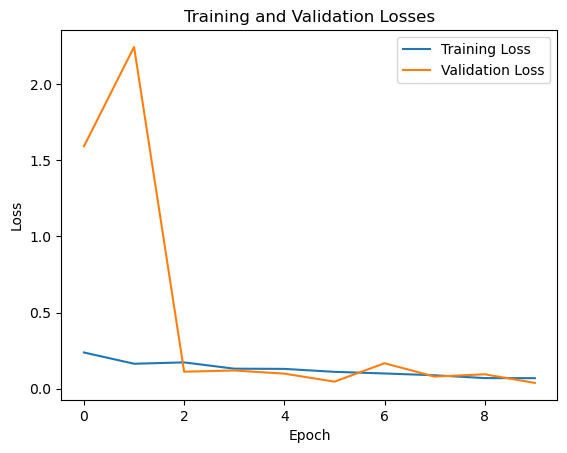

Testing DataLoader 0: 100%|██████████| 10/10 [00:02<00:00,  4.67it/s]

<Figure size 640x480 with 0 Axes>

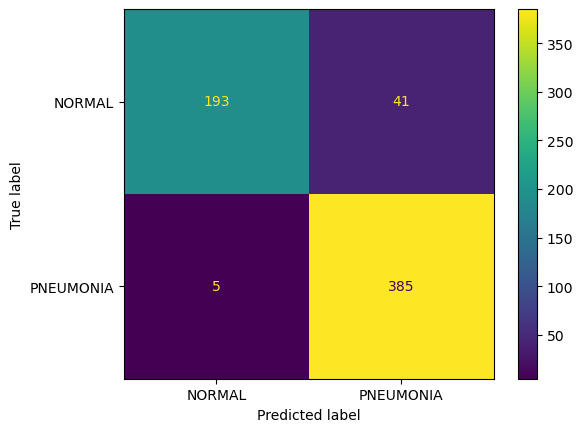

Testing DataLoader 0: 100%|██████████| 10/10 [00:02<00:00,  4.19it/s]
Best: F1= 0.9436, Acc= 0.9281
F1 = 0.94, accuracy = 0.93 
Running solution 2/5
CPU cores: 20, Device: cuda, GPU: NVIDIA GeForce RTX 3070 Ti Laptop GPU
Hyperparameters: 
{   'balance': True,
    'batch_size': 64,
    'early_stopping_patience': inf,
    'image_size': 224,
    'lr': 0.001,
    'model': 'resnet50',
    'num_epochs': 10,
    'scheduler': 'CosineAnnealingLR10',
    'use_best_checkpoint': False}
Testing DataLoader 0: 100%|██████████| 10/10 [00:01<00:00,  8.80it/s]
Best: F1= 0.9626, Acc= 0.9531
F1 = 0.96, accuracy = 0.95 
Running solution 3/5
CPU cores: 20, Device: cuda, GPU: NVIDIA GeForce RTX 3070 Ti Laptop GPU
Hyperparameters: 
{   'balance': True,
    'batch_size': 64,
    'early_stopping_patience': inf,
    'image_size': 224,
    'lr': 0.001,
    'model': 'resnet50',
    'num_epochs': 10,
    'scheduler': 'CosineAnnealingLR10',
    'use_best_checkpoint': False}
Testing DataLoader 0: 100%|██████████| 10/

In [8]:
repeats = 5
for i in range(repeats):
    print("===============================================")
    print(f"Running solution {i+1}/{repeats}")
    f1, accuracy = check_solution(hyperparameters, verbose=(i==0))
    print(f"F1 = {f1:.2f}, accuracy = {accuracy:.2f} ")
    f1_array = np.append(f1_array, f1)
    accuracy_array = np.append(accuracy_array, accuracy) 

In [9]:
# Calculate elapsed time
repeat_time = (time.time() - start_time) / repeats
repeat_time_min, repeat_time_sec = divmod(repeat_time, 60)

In [10]:
# Printing final results
print("Results")
print(f"F1: {np.mean(f1_array):.1%} (+-{np.std(f1_array):.1%})")
print(f"Accuracy: {np.mean(accuracy_array):.1%} (+-{np.std(accuracy_array):.1%})")
print(f"Time of one solution: {repeat_time_min:.0f}m {repeat_time_sec:.0f}s")
print(f" | {np.mean(f1_array):.1%} (+-{np.std(f1_array):.1%}) | {np.mean(accuracy_array):.1%} (+-{np.std(accuracy_array):.1%}) | {repeat_time_min:.0f}m {repeat_time_sec:.0f}s")

Results
F1: 94.6% (+-1.4%)
Accuracy: 93.1% (+-2.0%)
Time of one solution: 23m 44s
 | 94.6% (+-1.4%) | 93.1% (+-2.0%) | 23m 44s


In [11]:
# Print hyperparameters
print("Hyperparameters:")
pprint.pprint(hyperparameters, indent=4)

Hyperparameters:
{   'balance': True,
    'batch_size': 64,
    'early_stopping_patience': inf,
    'image_size': 224,
    'lr': 0.001,
    'model': 'resnet50',
    'num_epochs': 10,
    'scheduler': 'CosineAnnealingLR10',
    'use_best_checkpoint': False}


In [37]:
import os
import numpy as np
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image
import matplotlib.pyplot as plt
from resnet50_config_test import hyperparameters
from models import PneumoniaModel

# === Load your model ===
model_path = r"E:\Quang's directory\FPT curriculushit\5th Sem\AIH301m\Project\models\ResNet50\epoch=9-step=660.ckpt"
model = PneumoniaModel.load_from_checkpoint(model_path, hyperparams=hyperparameters)
model.eval().cuda()

# === GradCAM Config ===
target_layers = [model.model.layer4[-1]]  # Last convolutional layer in ResNet50

# === Transform Config (matching dataloader.py) ===
transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# === Visualization Transform (for display image) ===
vis_transform = A.Compose([
    A.Resize(224, 224)  # Resize to match model input and heatmap
])

# === Visualization Function ===
def visualize_gradcam(image_path):
    # Load and preprocess image
    img = Image.open(image_path).convert('RGB')
    img_np = np.array(img).astype(np.float32)  # Convert to NumPy array

    # Preprocess for model input
    img_transformed = transform(image=img_np)["image"] / 255.0  # Apply transform and scale
    input_tensor = img_transformed.unsqueeze(0).cuda()  # Add batch dimension

    # Preprocess for visualization (resize only)
    img_resized = vis_transform(image=img_np)["image"] / 255.0  # Resize to 224x224 and normalize to [0, 1]

    # Predict class
    with torch.no_grad():
        outputs = model(input_tensor)
        probs = torch.softmax(outputs, dim=1)
        conf, pred_class = torch.max(probs, dim=1)
        conf_val = conf.item()
        pred_idx = pred_class.item()
        pred_label = "Pneumonia" if pred_idx == 1 else "Normal"

    # GradCAM
    cam = GradCAM(model=model, target_layers=target_layers)
    targets = [ClassifierOutputTarget(pred_idx)]  # Use predicted class
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

    # Normalize CAM
    grayscale_cam = (grayscale_cam - grayscale_cam.min()) / (grayscale_cam.max() - grayscale_cam.min() + 1e-8)

    # Overlay heatmap
    heatmap = show_cam_on_image(img_resized, grayscale_cam, use_rgb=True)

    # Show side-by-side
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(img)
    axs[0].set_title("Original Image")
    axs[0].axis("off")

    axs[1].imshow(heatmap)
    axs[1].set_title(f"Grad-CAM\n{pred_label} ({conf_val:.2f})")
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()

Processing: person1946_bacteria_4874.jpeg


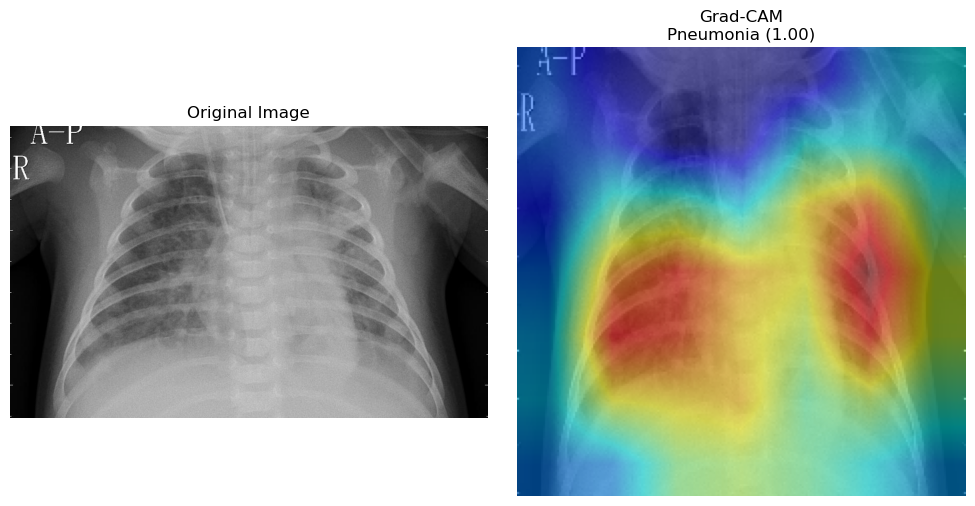

Processing: person1946_bacteria_4875.jpeg


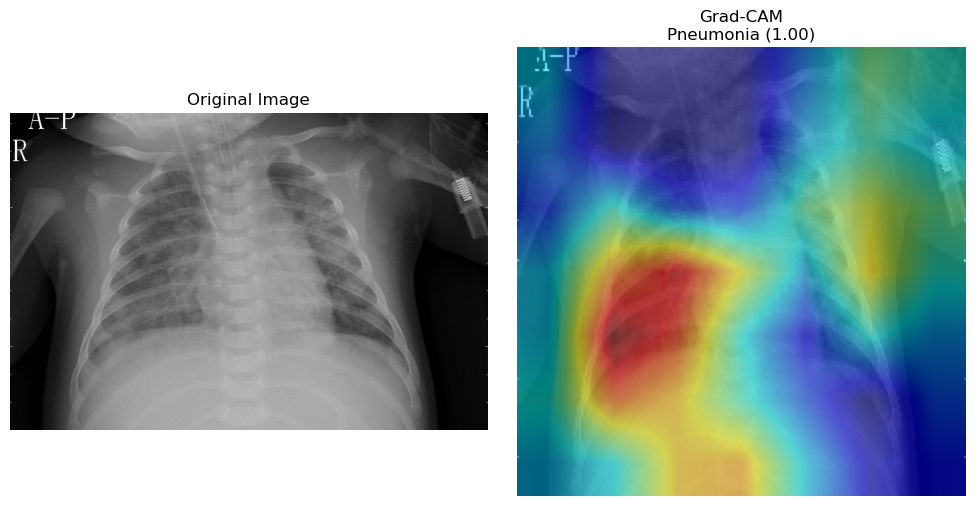

Processing: person1947_bacteria_4876.jpeg


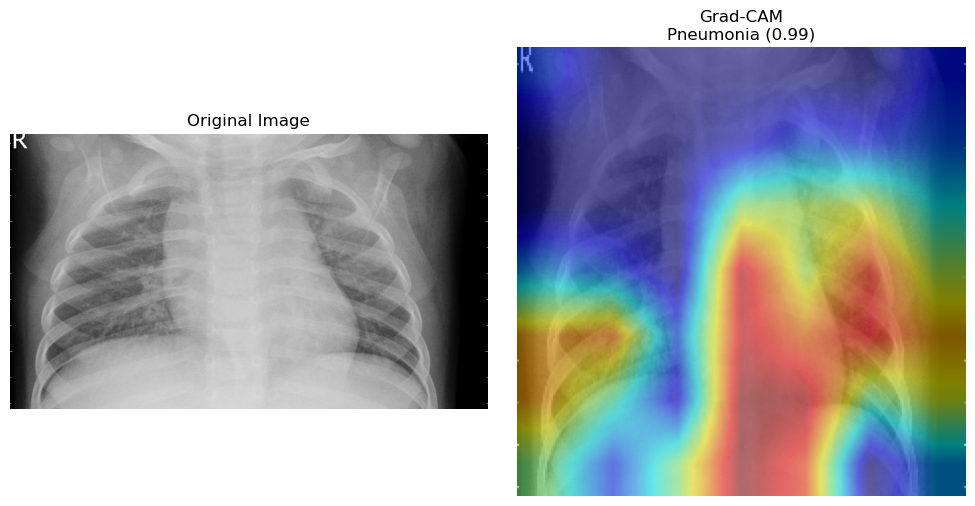

Processing: person1949_bacteria_4880.jpeg


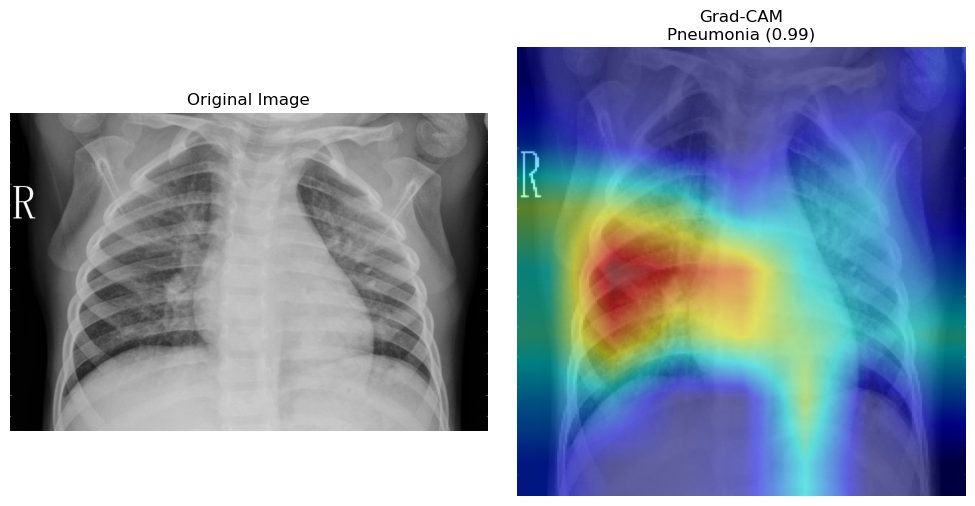

Processing: person1950_bacteria_4881.jpeg


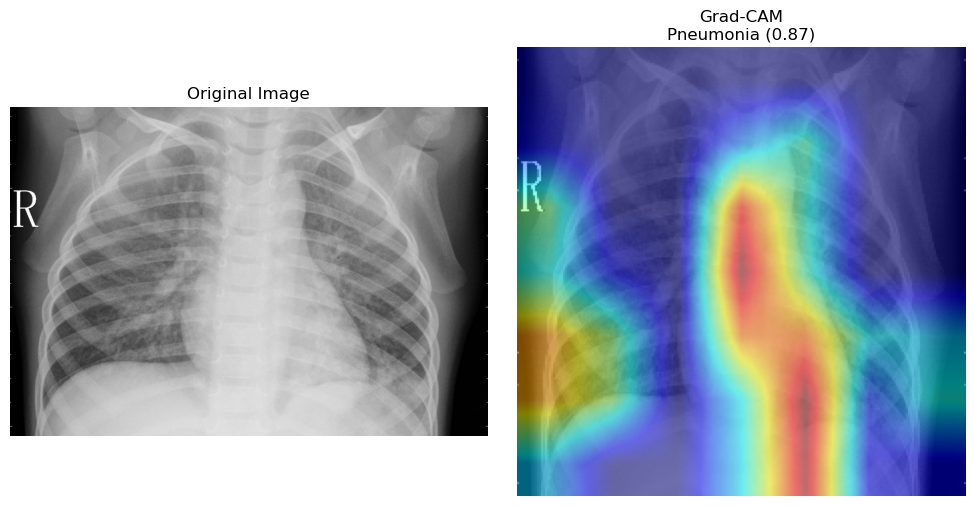

In [38]:
image_folder = r"E:\Quang's directory\FPT curriculushit\5th Sem\AIH301m\Project\chest_xray\val\PNEUMONIA"
image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(".jpeg")]

for path in image_files[:5]:  # Limit to 5 images for speed
    print(f"Processing: {os.path.basename(path)}")
    visualize_gradcam(path)


Processing: NORMAL2-IM-1427-0001.jpeg


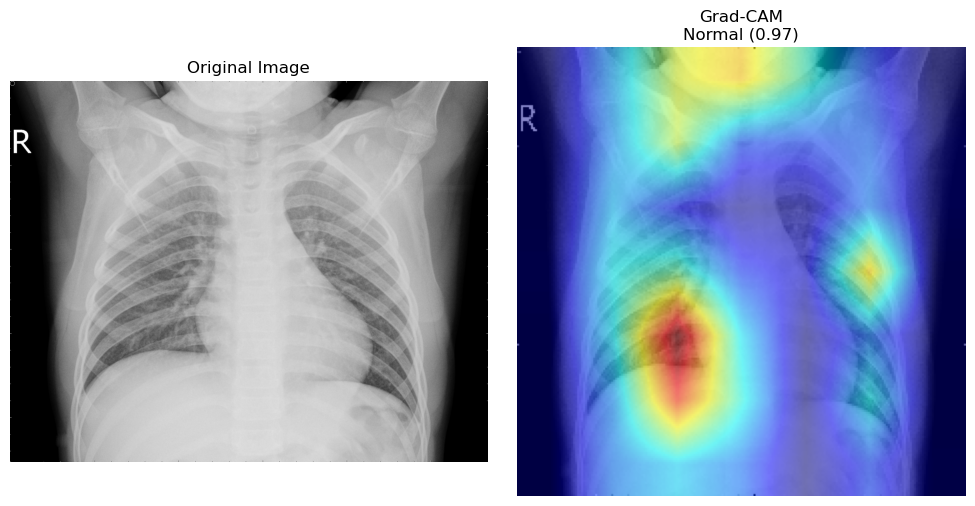

Processing: NORMAL2-IM-1430-0001.jpeg


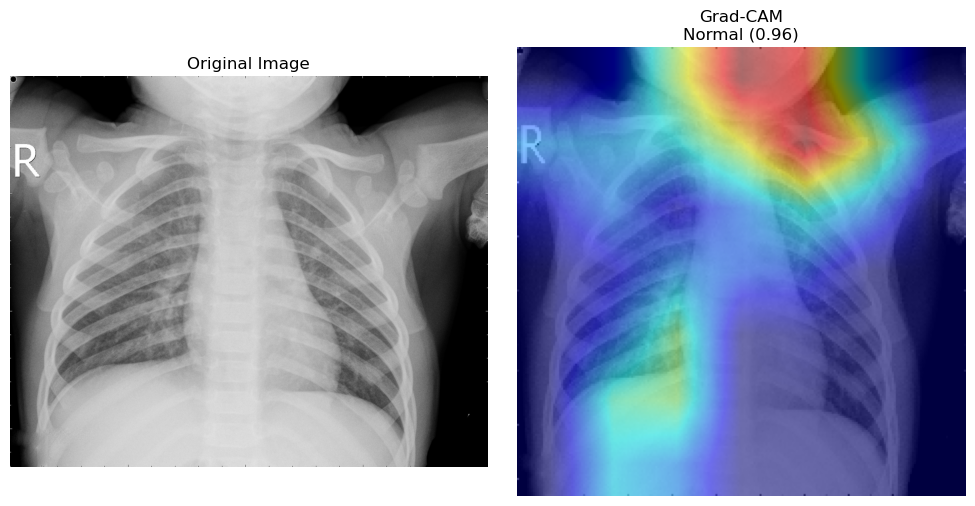

Processing: NORMAL2-IM-1431-0001.jpeg


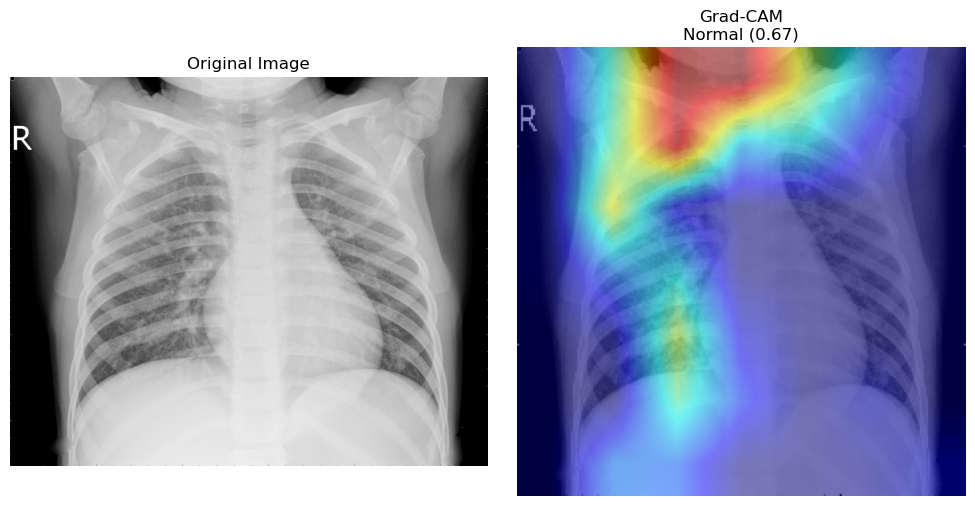

Processing: NORMAL2-IM-1436-0001.jpeg


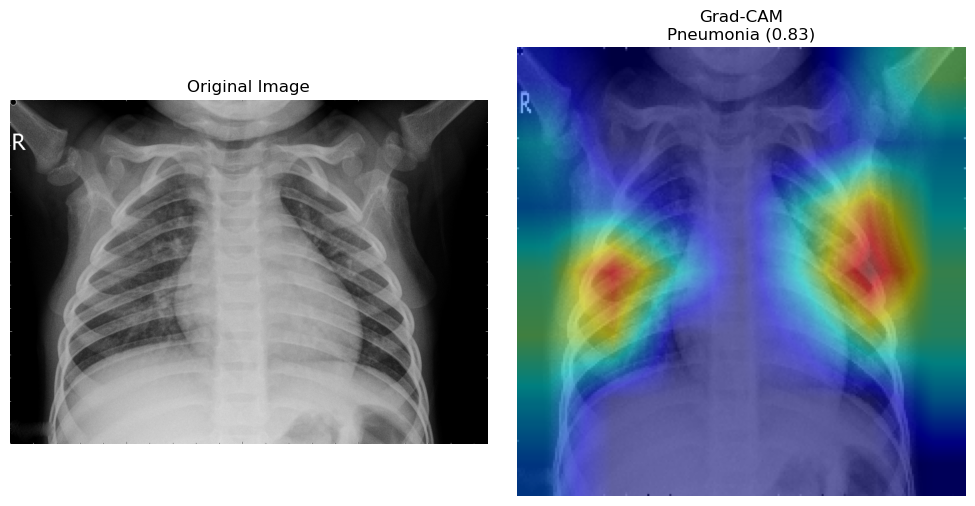

Processing: NORMAL2-IM-1437-0001.jpeg


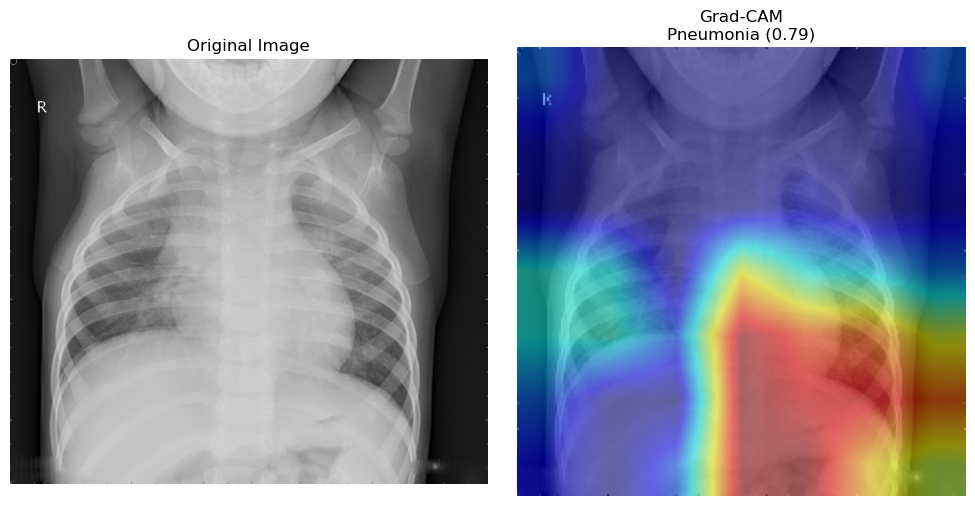

In [39]:
image_folder = r"E:\Quang's directory\FPT curriculushit\5th Sem\AIH301m\Project\chest_xray\val\NORMAL"
image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(".jpeg")]

for path in image_files[:5]:  # Limit to 5 images for speed
    print(f"Processing: {os.path.basename(path)}")
    visualize_gradcam(path)